## Laplace Equation
Laplace Equation은 비압축성, 비회전류 유동에서 정상상태일 때 Velocity Potential 또는 Streamfunction의 해이다.

$$
\nabla^2 u = 0.
$$

간단한 예제로 Heat Conduction에 의해 Steady State에 도달하는 경우를 생각하자

예를 들면, 윗면에 온도만 300도이고 나머지 면의 온도가 100도인 경우 최종적으로 2차원 공간 내 온도 분포는 Laplace Equation으로 구할 수 있다.

$[0,1]^2$ 공간에 대해 수식으로 표현하면 다음과 같다.

$$
-k (T_{xx} + T_{yy}) = 0\\
T(x,1) = 300, T(x, 0) = T(0, y) = T(1, y) = 100
$$

편의상 $k=1$ 로 생각한다.

### Finite Difference Method
그림과 같이 계산 영역을 x, y 각 방향별로 균일하게 나누어서 생각하자.

:::{figure-md} Grid
<img src="figures/2d_fd_grid.png">

Grid
:::

이 경우 2차원 Array는 각 격자점의 해와 부합한다.

각 방향별 편미분을 2차 정확도 Central Difference로 표현하면 다음과 같다.

$$
\frac {T_{i+1,j} -2 T_{i,j} +  T_{i-1,j}}{\Delta x^2}
+
+\frac {T_{i,j+1}^n -2 T_{i,j}^n +  T_{i,j-1}^n}{\Delta y^2}
=0
$$

$\Delta x = \Delta y = h$ 인 경우 다음과 같이 정리된다.

$$
T_{i+1,j} + T_{i,j+1} - 4 T_{i,j} + T_{i,j-1} + T_{i-1,j}
=0
$$

이를 Matrix 형태로 나타내면 다음과 같다.

$$
\left [
\begin{matrix}
-4 & 1 &   & 1 &   &   &   &   &
\\ 
 1 &-4 & 1 &   & 1 &   &   &   &
\\
   & 1 &-4 &   &   & 1 &   &   &
\\
 1 &   &   &-4 & 1 &   & 1 &   & 
\\
   & 1 &   & 1 &-4 & 1 &   & 1 & 
\\
   &   & 1 &   & 1 &-4 &   &   & 1
\\
   &   &   & 1 &   &   &-4 & 1 & 
\\
   &   &   &   & 1 &   & 1 &-4 & 1
\\
   &   &   &   &   & 1 &   & 1 &-4
\end{matrix}
\right ]
\left [
\begin{matrix}
T_{1,1} \\
T_{1,2} \\
T_{1,3} \\
T_{2,1} \\
T_{2,2} \\
T_{2,3} \\
T_{3,1} \\
T_{3,2} \\
T_{3,3} 
\end{matrix}
\right ]
=
\left [
\begin{matrix}
-T_{1,0} & -T_{0,1} \\ & -T_{0,2} \\ - T_{1,4} &-T_{0,3}  \\
-T_{2,0} & \\ 0 \\ -T_{2,4} &  \\
-T_{3,0} &-T_{4,1} \\ &-T_{4,2} \\ - T_{3,4}& -T_{4,3}
\end{matrix}
\right ]
$$

단 한번에 역행렬을 구함으로 써 모든 점에서 온도를 구할 수 있다.

다만 공간 차분 점이 늘어날수록 역행렬을 계산하는 시간이 급격하게 늘어난다.

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import math
from numpy import linalg
from numba import cuda
import time

plt.style.use('ggplot')
plt.rcParams['figure.dpi'] = 150

## Iterative Methods

### 개념
매우 큰 행렬 System $Ax=b$ 를 반복해서 푸는 방법이다.

기본 개념은 다음과 같다.
- $A = A_1 - A_2$
   - $A_1$ 은 역행렬을 쉽게 구해지는 형태이다.
   
$$
A_1 x = A_2 x + b
$$
   
- 반복되는 해를 $x^{(k)}$ 하고 이를 적용한다.

$$
A_1 x^{(k+1)} = A_2 x^{(k)}+ b
$$

- $x^{(k)} \rightarrow x$ 이면 오차 $e^{(k)} = x^{(k+1)} - x^{(k)} \rightarrow 0$ 이다. 즉 오차가 $e^{(k)}$ 감소할 때 까지 반복한다.

   - 모든 경우에 오차가 감소하지 않는다. $A_1^{-1} A_2$ 의 Eigenvalue가 모두 1 보다 작아야 한다.
   
   
### Point Jacobi Method
이 방법은 $A_1 = D$ 로 한 경우이다.

Laplace 문제에 적용하면 다음과 같이 표현할 수 있다.

$$
T_{i, j}^{(n+1)} = \frac{1}{4} \left (
T_{i+1,j}^{(n)} + T_{i,j+1}^{(n)} + T_{i,j-1}^{(n)} + T_{i-1,j}^{(n)}
\right )
$$

In [2]:
def jacobi(n, ti, dt):
    """
    Jacobi method
    
    Parameters
    ----------
    n : integer
        size
    ti : float
        current time
    dt : array
        difference
    """
    for i in range(1, n+1):
        for j in range(1, n+1):
            dt[i, j] = 0.25*(ti[i-1, j] + ti[i, j-1] + ti[i+1, j] + ti[i, j+1]) - ti[i, j]
            
def jacobi_v1(ti, dt):
    """
    Jacobi method (Vector version)
    
    Parameters
    ----------
    n : integer
        size
    ti : float
        current time
        
    Parameters
    -----------
    dt : array
        difference
    """
    dt[1:-1, 1:-1] = 0.25*(ti[:-2, 1:-1] + ti[1:-1, :-2] + ti[2:, 1:-1] + ti[1:-1, 2:]) - ti[1:-1, 1:-1]

In [3]:
def bc(t):
    t[-1, 1:-1] = 300   # upper side
    t[0, 1:-1] = 100    # lower side
    t[1:-1, -1] = 100   # Right
    t[1:-1, 0] = 100    # Left
  

In [4]:
def Laplace_serial(n, tol):

    ti = np.zeros((n+2, n+2))
    dt = np.zeros((n+2, n+2))
            
    err = 1
    hist_jacobi = []

    while err > tol:
        # Apply BC
        bc(ti)
        
        # Run Jacobi
        #jacobi(n, ti, dt)
        jacobi_v1(ti, dt)
        
        # Compute Error
        err = linalg.norm(dt) / n
        hist_jacobi.append(err)
        
        # Update solution
        ti += dt

    return ti

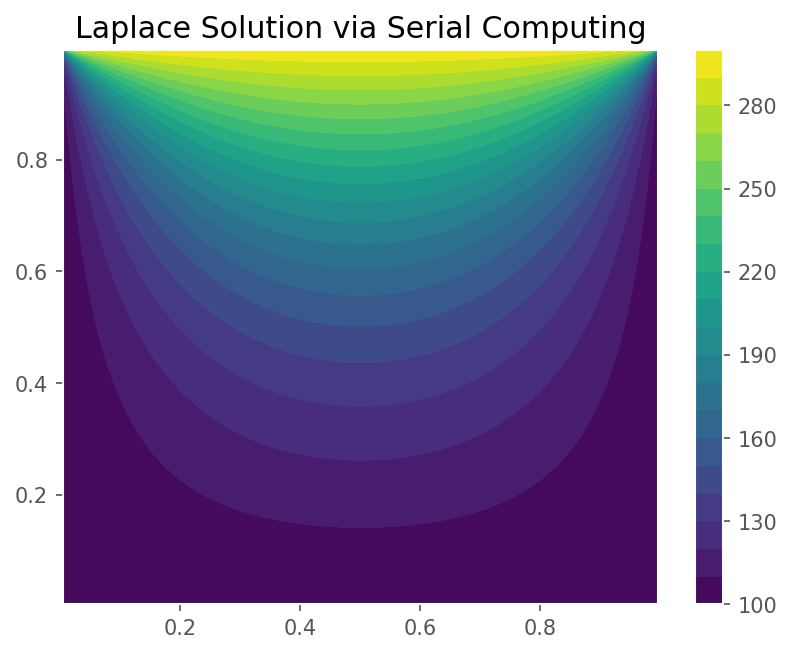

In [5]:
# Generate points (excluding BC)
n= 254
tol = 1e-5
xi = np.linspace(0, 1, n+2)
xx, yy = np.meshgrid(xi[1:-1], xi[1:-1])
ti_serial = Laplace_serial(n, tol)

# Plot contour
plt.contourf(xx, yy, ti_serial[1:-1, 1:-1], levels=20)
plt.title("Laplace Solution via Serial Computing")
plt.colorbar()
plt.show()

In [6]:
@cuda.jit
def jacobi_gpu(n, ti, dt):
    i, j = cuda.grid(2)
    if 1 <= i <= n and 1 <= j <= n:
        dt[i, j] = 0.25*(ti[i-1, j] + ti[i, j-1] + ti[i+1, j] + ti[i, j+1]) - ti[i, j]

In [7]:
# 1~n까지가 내부 점, 경게조건은 외부
@cuda.jit
def bc_gpu(t):
    n = t.shape[0] - 2  # 내부 셀 개수
    i = cuda.grid(1)

    if 1 <= i <= n:
        t[0, i] = 100        # 아래쪽
        t[n+1, i] = 300      # 위쪽
        t[i, 0] = 100        # 왼쪽
        t[i, n+1] = 100      # 오른쪽


In [8]:
@cuda.jit
def add_array_gpu(ti, dt):
    i, j = cuda.grid(2)
    if i < ti.shape[0] and j < ti.shape[1]:
        ti[i, j] += dt[i, j]

In [ ]:
# @cuda.jit
# def compute_frobenius_norm(matrix, result):
#     # 2D thread index
#     i, j = cuda.grid(2)

#     # get matrix shape
#     rows, cols = matrix.shape

#     # 각 thread가 자기 자리의 제곱을 더함
#     tmp = 0.0
#     if i < rows and j < cols:
#         tmp = matrix[i, j] * matrix[i, j]

#     # 원자적 더하기로 결과를 하나의 값으로
#     cuda.atomic.add(result, 0, tmp)
#     result = math.sqrt(result[0])

In [ ]:
def Laplace_gpu(n, tol):

    ti = np.zeros((n+2, n+2))
    dt = np.zeros((n+2, n+2))
    
    d_ti = cuda.to_device(ti)
    d_dt = cuda.to_device(dt)

    # 2차원 그리드 결정
    threadsperblock = (16,16)
    blockspergrid_x = math.ceil((n+2) / threadsperblock[0])
    blockspergrid_y = math.ceil((n+2) / threadsperblock[1])
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    err = 1
    hist_jacobi = []

    while err > tol:
        
        # 경계 조건 일단 1D n개 쓰레드
        bc_gpu[1,n+2](d_ti)


        jacobi_gpu[blockspergrid, threadsperblock](n, d_ti, d_dt)
        #cuda.synchronize()
 
        dt = d_dt.copy_to_host()
        err = linalg.norm(dt) / n
        hist_jacobi.append(err)

        add_array_gpu[blockspergrid, threadsperblock](d_ti, d_dt)
        #cuda.synchronize()

    ti = d_ti.copy_to_host()
    
    return ti, hist_jacobi

- copy가 줄어들수록 시간이 급격히 감소, 업데이트를 커널에서 진행하고 계산 끝나면 최종 Ti만 업데이트 하도록.
- norm을 계산하는 문제는 여전히, 다른 방식으로 수렴을 결정할수 없을까

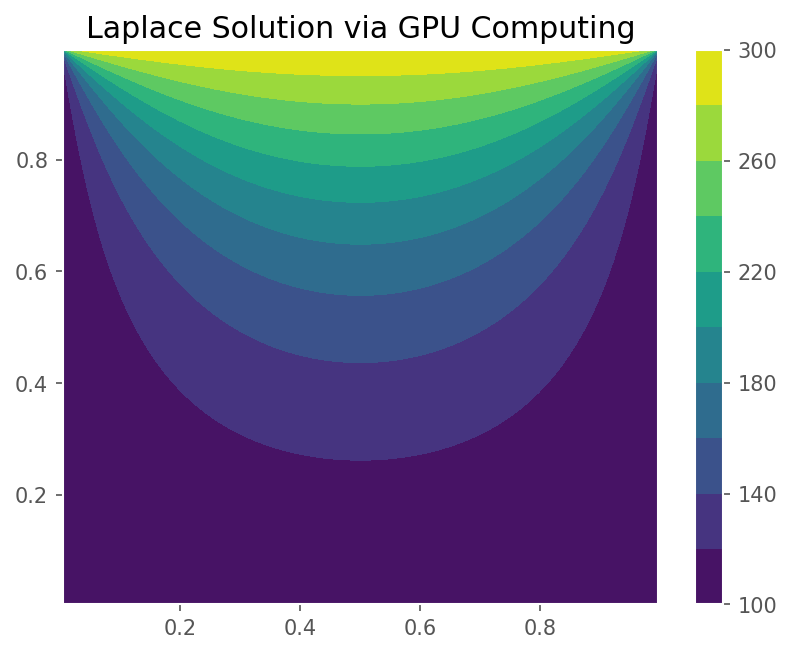

In [15]:
ti_gpu, _ = Laplace_gpu(n, tol)

# Plot contour
plt.contourf(xx, yy, ti_gpu[1:-1, 1:-1], levels=10)
plt.title('Laplace Solution via GPU Computing')
plt.colorbar()
plt.show()

In [13]:
error = ti_gpu - ti_serial

if linalg.norm(error) == 0:
    print("Serial Result Matches GPU computing Result")

Serial Result Matches GPU computing Result


In [ ]:
ns = [30, 126, 254]
times_cpu =[]
times_gpu =[]

for n in ns:
    t_s_cpu = time.time()
    Laplace_serial(n, tol)
    t_e_cpu = time.time()
    times_cpu.append(t_e_cpu - t_s_cpu)

for n in ns:
    t_s_gpu = time.time()
    Laplace_gpu(n, tol)
    t_e_gpu = time.time()
    times_gpu.append(t_e_gpu - t_s_gpu)

plt.plot(ns, times_cpu)
plt.plot(ns, times_gpu)
plt.title("Computing time vs Point n")
plt.legend('CPU', 'GPU')

## Occupancy Optimization

### Thread layout 설정을 통한 성능 가속화
- Occupancy 비율을 높이기
- Speed up 비교